In [1]:
import numpy as np
from sklearn import manifold
from apricot import FacilityLocationSelection
from apricot import FeatureBasedSelection
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import umap
from sklearn.manifold import TSNE

In [2]:
umap.UMAP

umap.umap_.UMAP

In [3]:
def getChrLen ( chr = 'chr1', assembly = 'hg19' ):
    chrsizes = np.loadtxt('/data/locusselect/' + assembly + '.chromsizes.txt',dtype={'names': ('chr','len'),'formats':('S6','i4')} )
    #print (chrsizes)
    for i in range(len(chrsizes)):
        if ( chrsizes[i][0].decode() == chr ):
            return (chrsizes[i][1] )
        
def generateWindows (chrs,res) :
        for chr in chrs:
                chrLen = getChrLen(chr)
                L = int(np.ceil(float(chrLen) / res ))
                starts = np.arange(0,L*res,res)
                ends = np.arange(res,(L+1)*res,res);    ends[-1] = chrLen
                chrNames = np.repeat(np.array([chr]),L)

        table = np.zeros(int(L), dtype={'names':('chr', 'start', 'end'),'formats':('S5', 'i4', 'i4')})
        table['chr'] = chrNames; table['start'] = starts+1; table['end'] = ends;
        return(table)

def averageMatrix(m,startRes=25,endRes=1000) :
        if endRes % startRes != 0 :
                print ("resolutions problematic, find a divisible one")
                return -1
        k = endRes / startRes
        (y,x) = np.shape(m)
        
        sliceSeq = np.arange(0,x,k)
        
        averagedM = np.zeros((y,int(np.ceil( x/float(k)))) )
        
        for i in range(len(sliceSeq)-1) :
                averagedM[:,i] = np.average(m[:,int(sliceSeq[i]):int(sliceSeq[i+1])],axis=1)

        averagedM[:,-1] = np.average(m[:,int(sliceSeq[-1]):x],axis=1)

        return (averagedM)

def chooseResolution (p, resolution='all') :
    if resolution == 'all' :
        p = p
    if resolution == 'high' :
        p = p[:,0:25]
    if resolution == 'mid' :
        p = p[:,25:65]
    if resolution == 'highmid' :
        p = p[:,0:65]
    if resolution == 'low' :
        p = p[:,65:110]
    return p
    
def umap_transform(peak_data, n_components=3, random_state=25, metric = 'correlation',n_neighbors=15,min_dist=0.1):
    umap_obj = umap.UMAP(n_components=n_components, random_state=random_state,
        min_dist=min_dist,metric=metric,n_neighbors=n_neighbors)
    try:
        umap_res = umap_obj.fit_transform(peak_data.toarray())
    except:
        umap_res = umap_obj.fit_transform(peak_data)
    return umap_res
    
def intersectBeds ( bed1, bed2, pickLargestOverlap = True ) :
    chrs1 = np.unique(bed1['f0']);  chrs2 = np.unique(bed2['f0'])
    allchrs = np.intersect1d(chrs1,chrs2)
    overlapInd1 = []; overlapInd2 = []; overlapLen = []
    for chr in allchrs :
        Ind1 = np.where(bed1['f0']==chr)[0];    Ind2 = np.where(bed2['f0']==chr)[0]
        midPoint1 = ( bed1['f2'][Ind1] + bed1['f1'][Ind1] ) / 2
        midPoint2 = ( bed2['f2'][Ind2] + bed2['f1'][Ind2] ) / 2
        int1 = bed1['f2'][Ind1] - bed1['f1'][Ind1] + 1
        int2 = bed2['f2'][Ind2] - bed2['f1'][Ind2] + 1
        maxInt = 2 * np.max(np.append(int1,int2))
        for I in range(len(Ind1)) :
            dist = np.abs( midPoint1[I] - midPoint2 )
            closeInd = Ind2[ np.where( dist < maxInt )[0] ]
            if len(closeInd) > 0 :
                for I2 in closeInd :
                    maxStart = max(bed1[Ind1[I]][1], bed2[I2][1])
                    minEnd = min(bed1[Ind1[I]][2], bed2[I2][2])
                    if maxStart < minEnd:
                        overlapInd1.append(Ind1[I])
                        overlapInd2.append(I2)
                        overlapLen.append(minEnd-maxStart)
                        
    overlapInd1 = np.array(overlapInd1); overlapInd2 = np.array(overlapInd2); overlapLen = np.array(overlapLen)
    
    uniqueOverlapInd1 = []; uniqueOverlapInd2 = []; uniqueOverlapLen = []
    if pickLargestOverlap == True :
        uniqueOI1 = np.unique(overlapInd1)
        for uI in uniqueOI1 :
            Ind = np.where(overlapInd1==uI)[0]
            Ord = np.argsort(overlapLen[Ind])
            uniqueOverlapInd1.append(uI); uniqueOverlapInd2.append(overlapInd2[Ind[Ord[-1]]]);
            uniqueOverlapLen.append(overlapLen[Ind[Ord[-1]]])
    
    uniqueOverlapInd1 = np.array(uniqueOverlapInd1); uniqueOverlapInd2 = np.array(uniqueOverlapInd2)
    uniqueOverlapLen = np.array(uniqueOverlapLen)
    
    return (uniqueOverlapInd1,uniqueOverlapInd2,uniqueOverlapLen)

def plot_embedding_3d(embedding, num_labels, label_dict, cmap=None):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    labels = np.unique(num_labels)
    scatter_res = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2],
     s=4, alpha=1,c=num_labels, cmap='jet')

    legend_proxies = []; legend_labels = []
    for label in label_dict.keys() :
        legend_color = cm.jet(label_dict[label] / float(len(label_dict.keys()) - 1))
        legend_proxies.append(matplotlib.lines.Line2D([0], [0], linestyle='none', c=legend_color, marker='o'))
        legend_labels.append(label)
    ax.legend(legend_proxies, legend_labels, numpoints=1, loc='upper left')#bbox_to_anchor=(1, 1))

def plot_embedding_2d(embedding, num_labels=None, label_dict=None, s_dict=None, a_dict=None, cmap=None, norm=None, title='' ):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    if num_labels is None or label_dict is None :
        scatter_res = ax.scatter(embedding[:,0], embedding[:,1], s=4, alpha=1)

    else :
        for label in label_dict.keys() :
            Ind = np.where(num_labels == label_dict[label])[0]
            color = cm.jet(label_dict[label] / float(len(label_dict.keys()) - 1))
            if s_dict is None : 
                dotsize = 4 
            else : 
                dotsize = s_dict[label]
            if a_dict is None : 
                alpha = 1
            else : 
                alpha = a_dict[label]
            scatter_res = ax.scatter(embedding[Ind,0], embedding[Ind,1], s=dotsize, alpha=alpha,c=color, label=label)
        ax.set_xlim( min(embedding[:,0]) - ( ( max(embedding[:,0]) - min(embedding[:,0]) ) * 0.5 ), max(embedding[:,0]) )
        ax.set_ylim( min(embedding[:,1]), max(embedding[:,1]) + ( ( max(embedding[:,1]) - min(embedding[:,1]) ) * 0.5 ) )
        ax.set_title(title)
        ax.legend(loc='upper left',prop={'size': 12})
          
def plotBox ( data, ax = None, arcsinhFlag = True, outliers = False, title = None ) :
    if arcsinhFlag : 
        plotData = [ np.arcsinh( data[:,i] ) for i in range(np.shape(data)[1]) ]    
    else :
        plotData = [ data[:,i] for i in range(np.shape(data)[1]) ]    
    if ax is None :
        plt.boxplot( plotData, showfliers = outliers )
        if title is not None :
            plt.title(title)
        plt.show()
    if ax is not None :
        ax.boxplot( plotData, showfliers = outliers )
        if title is not None :
            ax.set_title(title)

def parseAvocadoLocus ( chr, start, end, resolution = 'highmid', process = None, process_res = None, datapath = '/net/noble/vol2/home/gurkan/proj/2018locus_selection/Data/nn_avocado/raw/' ) :
    data = np.load(datapath+'genome_'+chr+'.npy')
    data_res = chooseResolution(data,resolution)

    #GET THE FACTORS at LOCUS OF INTEREST (MYC)
    startI = int(start / 25); endI = int(end / 25); 
    data_locus = data_res[np.arange(startI,endI),:]
    
    if process is not None and process_res is not None and process is 'average' :
        data_locus = np.transpose(averageMatrix(np.transpose(data_locus),25,process_res))
    if process is not None and process_res is not None and process is 'min' :
        data_locus = np.transpose(minMatrix(np.transpose(data_locus),25,process_res))
    return(data_locus)

def generateLocusWindows ( chr, start, end, resolution ) :
    windows = generateWindows([chr],resolution)
    startI = int(start / resolution); endI = int(end / resolution); 
    locus_windows = windows[np.arange(startI,endI)]
    locus_windows.dtype.names = ['f0','f1','f2']
    return (locus_windows)

def makeHistoneChIPMatrix (data, arcsinhFlag = True) :
    if arcsinhFlag : 
        data_list = [ np.arcsinh( data[fieldname] ) for fieldname in data.dtype.names[1:]]    
    else :
        data_list = [ data[fieldname] for fieldname in data.dtype.names[1:]]
    data_matrix = np.transpose(np.vstack(data_list))
    return(data_matrix)

def makeBed ( labels ) :
    chrNames = np.array ([ (coords.decode()).split('_')[0] for coords in labels ] )
    starts = np.array ([ int((coords.decode()).split('_')[1]) for coords in labels ] )
    ends = np.array ([ int((coords.decode()).split('_')[2]) for coords in labels ] )
    
    table = np.zeros(len(chrNames), dtype={'names':('f0', 'f1', 'f2'),'formats':('S5', 'i4', 'i4')})
    table['f0'] = chrNames; table['f1'] = starts+1; table['f2'] = ends;
    return(table)
    
def selectSubset ( data_matrix, n = None, distance = 'euclidean', initial_subset = None, selection_subset = None ) :
    if selection_subset is not None :
        data_matrix = data_matrix[selection_subset]
    
    if n is None :
        n = np.shape(data_matrix)[0]
    
    if initial_subset is None :
        model = FacilityLocationSelection(n, distance)
    else :
        model = FacilityLocationSelection(n, distance, initial_subset = initial_subset )
    
    Xi = model.fit_transform(data_matrix)
    SubsetInd = model.ranking
    Gains = model.gains
    
    if selection_subset is not None :
        SubsetInd = selection_subset[SubsetInd]
    
    return SubsetInd, Gains

def makeSegwayAnnotation ( loci_windows, segway_anno) :
    I1,I2,L1 = intersectBeds(loci_windows,segway_anno)

    if len(I1) == len(loci_windows) : 
        segway_labels = segway_anno['f3'][I2]
    else :
        segway_labels = np.repeat('0_Undetermined',len(loci_windows))
        segway_labels[I1] = segway_anno['f3'][I2]

    segway_labels = [ label.split('_')[1] for label in segway_labels ]
    segway_labels = np.array(segway_labels)
    unique_labels = np.unique(segway_labels)
    label_dict = {}
    for i in range(len(unique_labels)) :
        label_dict[unique_labels[i]] = i+1
    segway_num_labels = [ label_dict[label] for label in segway_labels ]
    
    return (segway_num_labels, label_dict)


def makeccREAnnotation ( loci_windows, ccREs ) :
    I1,I2,L1 = intersectBeds(loci_windows,ccREs)

    ccRE_num_labels = np.zeros(len(loci_windows))
    ccRE_num_labels[I1] = 1
    
    label_dict = { 'ccRE' : 1, 'All' : 0 }
    return (ccRE_num_labels, label_dict)

def makeSubsetAnnotation ( subsetInd, subsetSize = None, k = 100 ) :
    if subsetSize is None :
        subsetSize = len(subsetInd)
    subset_num_labels = np.zeros(subsetSize)
    subset_num_labels[subsetInd[0:k]] = 1
    
    label_dict = { 'Subset' : 1, 'All' : 0 }
    return (subset_num_labels, label_dict)

def makeGeneralAnnotation ( Ind_list, label_list, k ) :
    num_labels = np.zeros(k)
    
    label_dict = { 'All' : 0 }
    for i in range(len(Ind_list)) :
        num_labels[Ind_list[i]] = i + 1
        label_dict[label_list[i]] = i + 1
    return (num_labels, label_dict)

In [4]:
datapath='/data/locusselect/avocado_latent_factors/'

In [5]:
#DECLARE LIST OF LOCI OF INTEREST 
#WE SKIP GATA BECAUSE THERE IS NO AVOCADO DATA FOR IT
lociList = [ [ 'BCL11A', 'chr2', 59780500, 61780750 ], 
#['GATA1', 'chrX', 47644750, 49645000 ],
['HBA2', 'chr16', 60000, 1223000 ],
['HBE1', 'chr11', 4526750, 6527000 ],
['LMO2', 'chr11', 32891250, 34891500 ],
['MYC', 'chr8', 127748250, 129748500 ],
['RBM38', 'chr20', 54966250, 56966500 ] ]

avocado_gene_names = [ 'BCL11A',  'HBA2', 'HBE1', 'LMO2', 'MYC', 'RBM38' ]

In [6]:
#PROCESS AVOCADO LATENT FACTORS
#MAKE BED FILES FOR 250BP TILED LOCI
avocado_data_list = []; avocado_bed_list = []
for locus in lociList :
    avocado_data_list.append( parseAvocadoLocus(locus[1],locus[2],locus[3],process='average',process_res=250,datapath=datapath) )
    avocado_bed_list.append( generateLocusWindows(locus[1],locus[2],locus[3],250) )

In [7]:
print(avocado_bed_list)

[array([(b'chr2', 59780501, 59780750), (b'chr2', 59780751, 59781000),
       (b'chr2', 59781001, 59781250), ..., (b'chr2', 61780001, 61780250),
       (b'chr2', 61780251, 61780500), (b'chr2', 61780501, 61780750)],
      dtype=[('f0', 'S5'), ('f1', '<i4'), ('f2', '<i4')]), array([(b'chr16',   60001,   60250), (b'chr16',   60251,   60500),
       (b'chr16',   60501,   60750), ..., (b'chr16', 1222251, 1222500),
       (b'chr16', 1222501, 1222750), (b'chr16', 1222751, 1223000)],
      dtype=[('f0', 'S5'), ('f1', '<i4'), ('f2', '<i4')]), array([(b'chr11', 4526751, 4527000), (b'chr11', 4527001, 4527250),
       (b'chr11', 4527251, 4527500), ..., (b'chr11', 6526251, 6526500),
       (b'chr11', 6526501, 6526750), (b'chr11', 6526751, 6527000)],
      dtype=[('f0', 'S5'), ('f1', '<i4'), ('f2', '<i4')]), array([(b'chr11', 32891251, 32891500), (b'chr11', 32891501, 32891750),
       (b'chr11', 32891751, 32892000), ...,
       (b'chr11', 34890751, 34891000), (b'chr11', 34891001, 34891250),
       (b

In [8]:
#write bed list to file
for idx,bedlist in enumerate(avocado_bed_list):
    outfile = open("coordinates_"+str(idx)+".bed", 'w')
    for coord in bedlist:
        chrom, start, end = coord
        chrom = chrom.decode("utf-8")
        start = start-1
        #when anna expands, it's flanksize, center, flank-1
        #so we should give her code a summit location of
        assert (end-start)%2 == 0
        flanksize = int((end-start)/2)
        outfile.write(chrom+"\t"+str(start)+"\t"+str(end)
                      +"\t.\t.\t.\t.\t.\t.\t"+str(flanksize)+"\n")
    outfile.close()

In [9]:
!head coordinates_0.bed

chr2	59780500	59780750	.	.	.	.	.	.	125
chr2	59780750	59781000	.	.	.	.	.	.	125
chr2	59781000	59781250	.	.	.	.	.	.	125
chr2	59781250	59781500	.	.	.	.	.	.	125
chr2	59781500	59781750	.	.	.	.	.	.	125
chr2	59781750	59782000	.	.	.	.	.	.	125
chr2	59782000	59782250	.	.	.	.	.	.	125
chr2	59782250	59782500	.	.	.	.	.	.	125
chr2	59782500	59782750	.	.	.	.	.	.	125
chr2	59782750	59783000	.	.	.	.	.	.	125


In [10]:
datapath='/data/locusselect/k562_histone_marks/'

In [11]:
#DECLARE HISTONE MARK NAMES, PROCESS DATA
histone_data = np.genfromtxt(datapath+'K562.binsize_250.mean.in_loci_of_interest.txt',dtype=None,skip_header=1)
markNames = [ 'H2AFZ-human','H3K27ac-human','H3K27me3-human','H3K36me3-human','H3K4me1-human','H3K4me2-human',
             'H3K4me3-human','H3K79me2-human' ,'H3K9ac-human','H3K9me3-human' ]

locus_names = np.array ([ (coords.decode()).split('_')[-1] for coords in histone_data['f0'] ] )
histone_gene_names, loci_counts = np.unique(locus_names,return_counts=True)
bed = makeBed (histone_data['f0'])
#DROP GATA
histone_gene_names = histone_gene_names[[0,2,3,4,5,6]]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [12]:
#LOAD HISTONE MARK DATA, FILTER OUT NON-UNIQUE REGIONS
histone_data_list = []; histone_rawdata_list = []; histone_bed_list = []
for gene_name in histone_gene_names :
    Ind = np.where(locus_names==gene_name)[0]
    thisMatrix = makeHistoneChIPMatrix(histone_data[Ind],False);
    
    #FILTER OUT WINDOWS WITH NON-UNIQUE SCORES
    rs = np.sum(thisMatrix,1); urs, urscount = np.unique(rs,return_counts=True)
    filterInd = np.array([])
    for thisurs in urs[urscount > 1]:
        filterInd = np.append(filterInd,np.where(rs==thisurs)[0])
    filterInd = Ind[filterInd.astype(int)]
    Ind = np.setdiff1d(Ind,filterInd)
    
    histone_data_list.append(makeHistoneChIPMatrix(histone_data[Ind],True))
    histone_rawdata_list.append(makeHistoneChIPMatrix(histone_data[Ind],False))
    histone_bed_list.append(bed[Ind])

In [13]:
#the function for umap embeddings
def performEmbeddings ( data_list, n_components=2, random_state=2, metric= 'correlation' ) :
    embedding_list = []; 
    for data in data_list :
        embedding_list.append( umap_transform(data, n_components=2, random_state=2,metric=distanceMeasure) )
    return (embedding_list)

In [14]:
#RUN UMAP EMBEDDING for histone and avocado data
distanceMeasure = 'correlation'
avocado_embedding_list = performEmbeddings(avocado_data_list,metric=distanceMeasure); 
histone_embedding_list = performEmbeddings(histone_data_list,metric=distanceMeasure); 

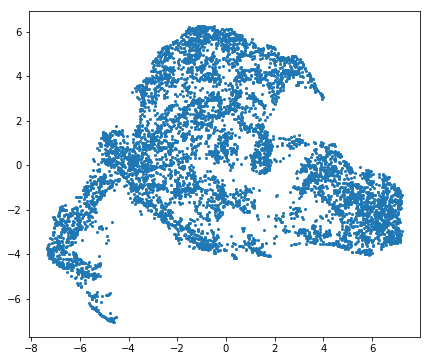

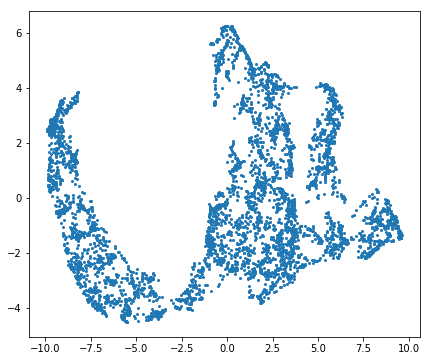

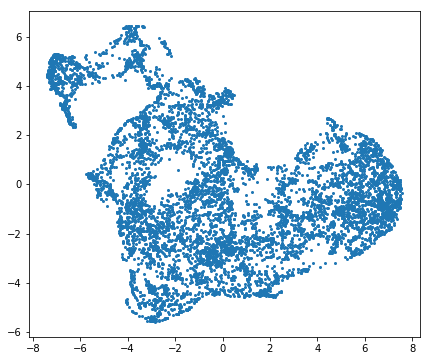

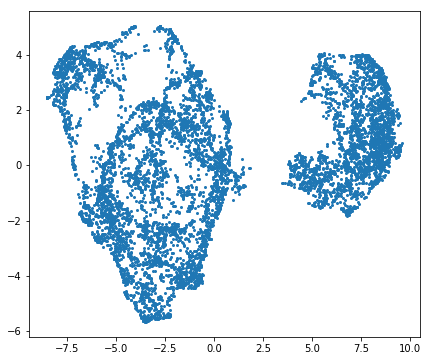

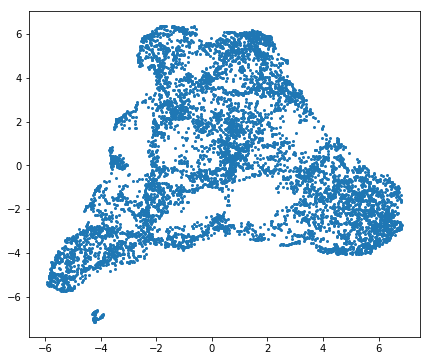

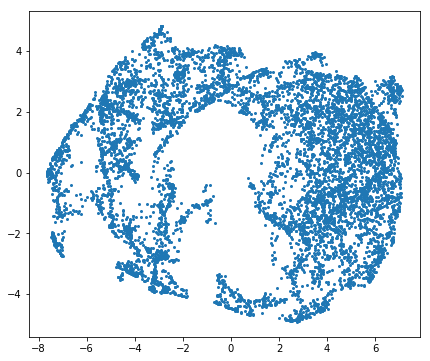

In [15]:
#PLOT 2D UMAP EMBEDDINGS FOR EACH GENE LOCI
for embedding in histone_embedding_list :
    plot_embedding_2d(embedding )

In [16]:
#SELECT REPRESENTATIVE SUBSET FOR EACH LOCUS, put it in a list
histone_SSIndex_list = []
for data in histone_data_list :
    N = np.shape(data)[0]
    SubsetInds,gains = selectSubset( data, n = N, distance = 'corr' )
    histone_SSIndex_list.append(SubsetInds)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

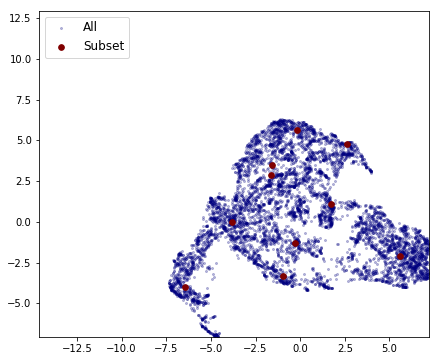

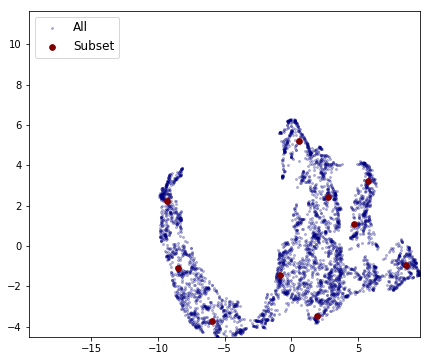

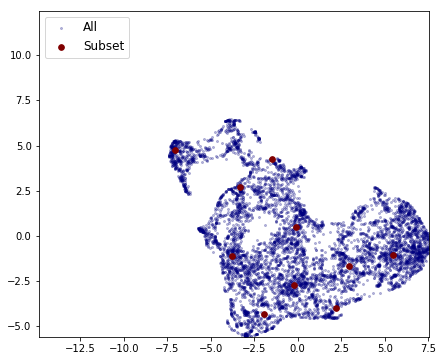

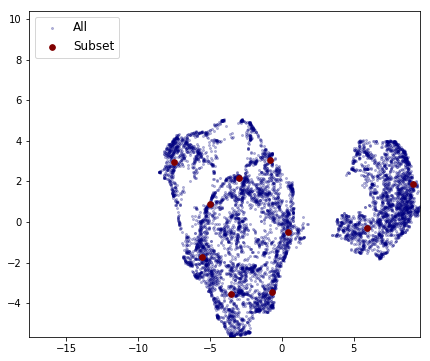

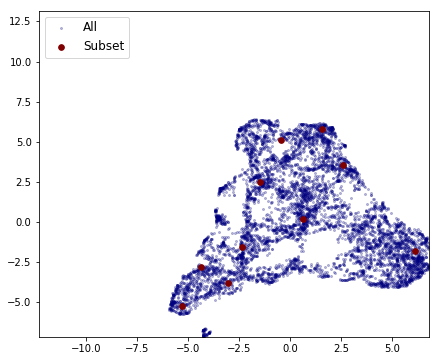

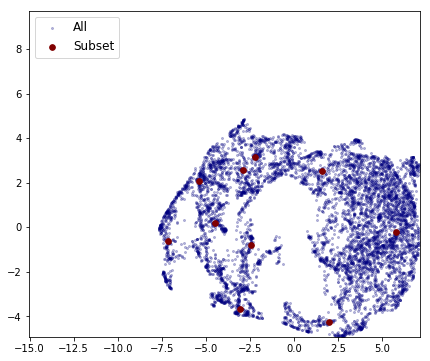

In [17]:
#VISUALIZE THE FIRST 10 ELEMENTS OF THE SUBSET IN THE EMBEDDING
ss_size = 10
size_dict = { 'Subset' : 32, 'All' : 4 }
alpha_dict = { 'Subset' : 1, 'All' : 0.25 }

for SSIndex, embedding in zip (histone_SSIndex_list,histone_embedding_list) :
    num_labels, label_dict = makeGeneralAnnotation ( [SSIndex[0:ss_size]], 
        ['Subset'], k = np.shape(embedding)[0] )
    plot_embedding_2d(embedding, num_labels, label_dict, s_dict = size_dict, a_dict = alpha_dict  )


In [60]:
def get_feature_explanations(feature_matrix, selected_exemplars, similarity_func, explain_diff_from_ref):
    
    exemplar_explanations = [] #to return  
    exemplar_avg_of_represented_points = []
    
    #create a mapping from points to their best and second best exemplars
    exemplars_for_points = []
    secondbest_exemplars_for_points = []
    for apoint_features in feature_matrix:
        #get similarities between this point and all the other exemplars
        exemplar_similarities = [(similarity_func(apoint_features, feature_matrix[some_exemplar]), some_exemplar)
                                 for some_exemplar in selected_exemplars]
        highest_similarity, exemplar_with_highest_similarity = max(exemplar_similarities, key=lambda x: x[0])
        (second_highest_similarity,
         exemplar_with_second_highest_similarity) = max(
            [y for y in exemplar_similarities if y[1] != exemplar_with_highest_similarity],
            key=lambda x: x[0])
        assert second_highest_similarity <= highest_similarity
        assert exemplar_with_second_highest_similarity != exemplar_with_highest_similarity        
        exemplars_for_points.append(exemplar_with_highest_similarity)
        secondbest_exemplars_for_points.append(exemplar_with_second_highest_similarity)
    
    exemplars_for_points = np.array(exemplars_for_points)
    secondbest_exemplars_for_points = np.array(secondbest_exemplars_for_points)
    
    for exemplar in selected_exemplars:
        features_of_exemplar = feature_matrix[exemplar]     
        closest_points_mask = exemplars_for_points == exemplar
        
        features_of_closest_points = feature_matrix[closest_points_mask]
        exemplar_avg_of_represented_points.append(np.mean(features_of_closest_points, axis=0))
        secondbest_exemplars_for_each_closest_point = secondbest_exemplars_for_points[closest_points_mask]
        features_of_secondbest_exemplars_for_each_closest_point = feature_matrix[secondbest_exemplars_for_each_closest_point]
        
        feature_contributions_for_each_point = []
        for features_of_point, features_of_secondbest_exemplar in zip(features_of_closest_points,
                                                                      features_of_secondbest_exemplars_for_each_closest_point):
            feature_contributions = explain_diff_from_ref(features_of_point=features_of_point,
                                                          features_of_exemplar=features_of_exemplar,
                                                          features_of_secondbest_exemplar=features_of_secondbest_exemplar)
            feature_contributions_for_each_point.append(feature_contributions)
        
        exemplar_explanations.append(np.mean(feature_contributions_for_each_point, axis=0))
        
    return exemplar_explanations, exemplar_avg_of_represented_points

def negative_squared_euclidean_similarityfunc(a, b):
    return -np.sum(np.square(a-b))

def negsquaredeuclidean_explain_diff_from_ref(features_of_point, features_of_exemplar, features_of_secondbest_exemplar):
    return (np.square(features_of_point-features_of_exemplar)
            - np.square(features_of_point-features_of_secondbest_exemplar))

def negative_squared_corr_similarityfunc(a, b):
    return np.corrcoef(a, b)[0, 1]

def corr_explain_diff_from_ref(features_of_point, features_of_exemplar, features_of_secondbest_exemplar):
    return (features_of_point * features_of_exemplar
            - features_of_point * features_of_secondbest_exemplar)


    
explanations, avg_of_represented_points = get_feature_explanations(
    feature_matrix=data,
    selected_exemplars=SubsetInds[:10],
    similarity_func=negative_squared_corr_similarityfunc,
    explain_diff_from_ref=negsquaredeuclidean_explain_diff_from_ref)
    

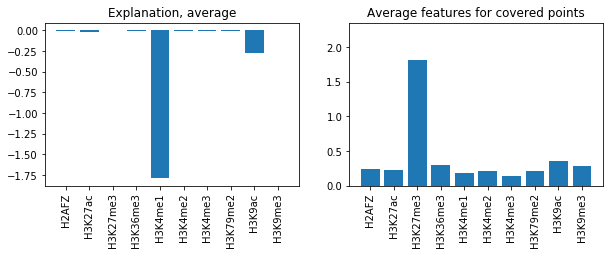

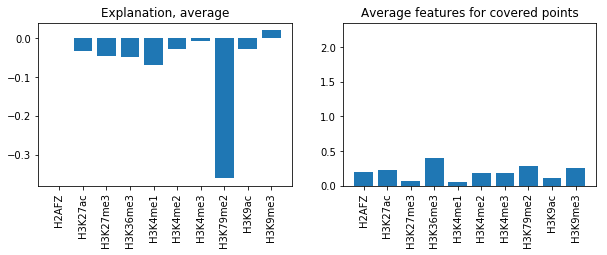

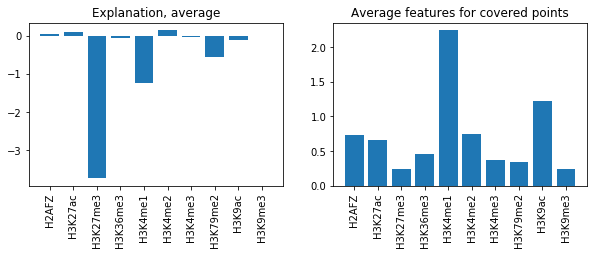

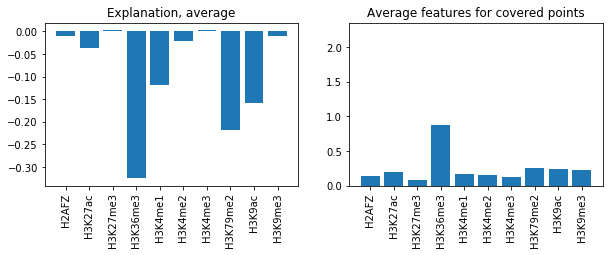

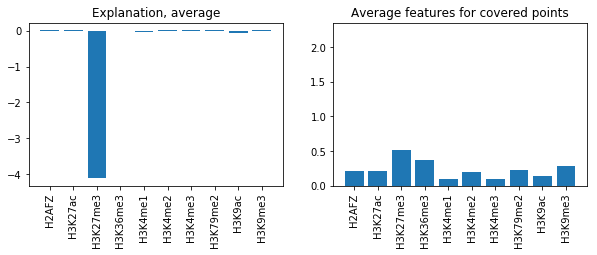

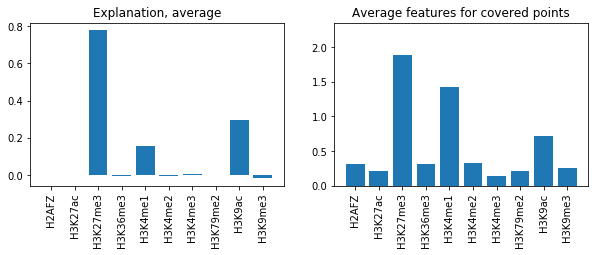

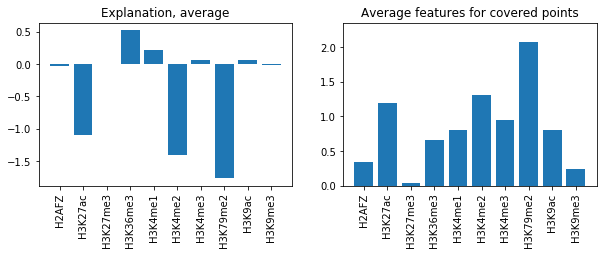

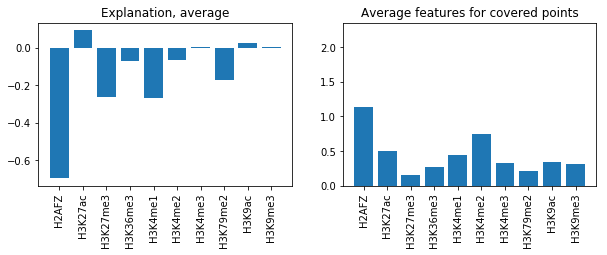

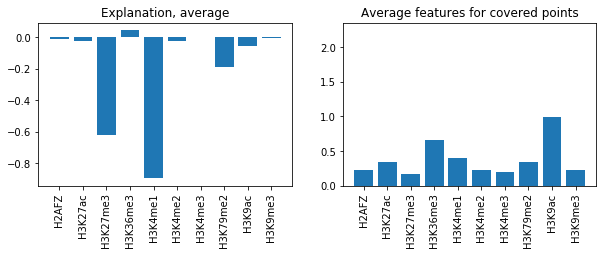

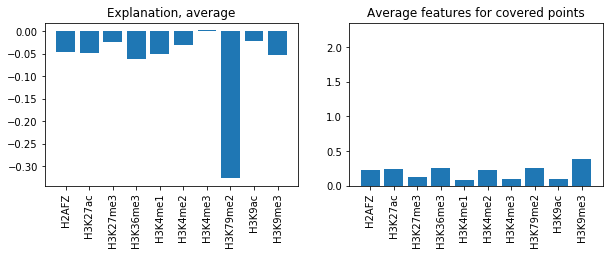

In [65]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

markNames_abbr = [name.replace("-human", "") for name in markNames]

max_y = np.max(avg_of_represented_points) + 0.1

for explanation, avg_features in zip(explanations,avg_of_represented_points):
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(len(explanation)), explanation)
    plt.xticks(np.arange(len(explanation)), markNames_abbr, rotation=90)
    plt.title("Explanation, average")
    #plt.show()
    
    
    
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(len(explanation)), avg_features)
    plt.xticks(np.arange(len(explanation)), markNames_abbr, rotation=90)
    plt.title("Average features for covered points")
    axes = plt.gca()
    axes.set_ylim([0,max_y])
    plt.show()    